# TensorFlow 
## Reinforcement Learning (Q-Learning) for Atari Games
### by [Sameer Kumar](https://sites.google.com/view/bvsk35/home?authuser=0)

# Part 1

## Introduction
Here we see learn about Reinforcement Learning in which an agent is learning how to navigate some environment, in this case Atari games from the 1970-80's. The agent does not know anything about the game and must learn how to play it from trial and error. The only information that is available to the agent is the screen output of the game, and whether the previous action resulted in a reward or penalty.

This is a very difficult problem in Machine Learning / Artificial Intelligence, because the agent must both learn to distinguish features in the game-images, and then connect the occurence of certain features in the game-images with its own actions and a reward or penalty that may be deferred many steps into the future.

This problem was first solved by the researchers from Google DeepMind. This code is based on the main ideas from their research papers [this](https://arxiv.org/abs/1312.5602) and [this](https://www.nature.com/articles/nature14236). Several changes have been made to the original DeepMind algorithm complicated in some ways. But it turns out that we still need several tricks in order to stabilize the training of the agent, hence this code is also complicated.

The basic idea is to have the agent estimate so-called Q-values whenever it sees an image from the game-environment. The Q-values tell the agent which action is most likely to lead to the highest cumulative reward in the future. The problem is then reduced to finding these Q-values and storing them for later retrieval using a function approximator (here it is Neural Network).

For detailed mathematical formulation of this problem please refer to Sergey Levine course on [Deep Reinforcement Learning](http://rail.eecs.berkeley.edu/deeprlcourse/).  

## The Problem
Here we use the Atari game Breakout, where the player or agent is supposed to hit a ball with a paddle, thus avoiding death while scoring points when the ball smashes pieces of a wall.

When a human learns to play a game like this, the first thing to figure out is what part of the game environment you are controlling - in this case the paddle at the bottom. If you move right on the joystick then the paddle moves right and vice versa. The next thing is to figure out what the goal of the game is - in this case to smash as many bricks in the wall as possible so as to maximize the score. Finally you need to learn what to avoid - in this case you must avoid dying by letting the ball pass beside the paddle.

Below are shown 3 images from the game that demonstrate what we need our agent to learn. In the image to the left, the ball is going downwards and the agent must learn to move the paddle so as to hit the ball and avoid death. The image in the middle shows the paddle hitting the ball, which eventually leads to the image on the right where the ball smashes some bricks and scores points. The ball then continues downwards and the process repeats.

![alt text](Images/3.png "Fig.1")

The problem is that there are 10 states between the ball going downwards and the paddle hitting the ball, and there are an additional 18 states before the reward is obtained when the ball hits the wall and smashes some bricks. How can we teach an agent to connect these three situations and generalize to similar situations? The answer is to use Reinforcement Learning with a Neural Network. 

## Q-Learning
Here we are using a *Model Free Reinforcement Learning Algorithm* known as *Q-Learning* where we try to **learn maximize our objective (formulated using a reward function) but avoid learning how states are being evolved**. Reward functions have the information regarding our complex goals that we wish our computer/robot to perform and rewards also guide the learning. This class of algorithms have their own advantage and disadvantage. 

Here we want to estimate **Q-values** which are also called action-values, because they *map a state of the game-environment to a numerical value for each possible action that the agent may take*. The Q-values indicate which action is expected to result in the *highest future reward*, thus telling the agent which action to take.

Unfortunately we do not know what the Q-values are supposed to be, so we have to estimate them somehow. The Q-values are all initialized to zero and then updated repeatedly as new information is collected from the agent playing the game. When the agent scores a point then the Q-value must be updated with the new information.

There are different formulas for updating Q-values, but the simplest is to set the new Q-value to the reward that was observed, plus the maximum Q-value for the following state of the game. This gives the total reward that the agent can expect from the current game-state and onwards. Typically we also multiply the max Q-value for the following state by a term discount-factor which is slightly below 1 (even 0.99 will also work). *This causes more distant rewards to contribute less to the Q-value, thus making the agent favour rewards that are closer in time*.

The formula for updating the Q-value is:`Q-value for given state and action = reward + discount * max Q-value for next state`.

When expressed mathematically it is <br>
<center>
$
    Q(s_{i}, a_{i}) \leftarrow \underbrace{r(s_{i}, a_{i})}_{\text{reward}} + \underbrace{\gamma}_{\text{discount}} * \underbrace{max_{a^{'}}Q(s^{'}_{i}, a^{'}_{i})}_{\text{estimate of future rewards}}.
$
</center>

## Example 1
The images below demonstrate how Q-values are updated in a backwards sweep through the game-states that have previously been visited. In this simple example we assume all Q-values have been initialized to zero. The agent gets a reward of 1 point in the right-most image. This reward is then propagated backwards to the previous game-states, so when we see similar game-states in the future, we know that the given actions resulted in that reward.

The discounting is an exponentially decreasing function. This example uses a discount-factor of `0.97` so the Q-value for the 3rd image is about $0.885 \simeq 0.97^4$ because it is four states prior to the state that actually received the reward. Similarly for the other states. This example only shows one Q-value per state, but in reality there is one Q-value for each possible action in the state, and the Q-values are updated in a backwards-sweep using the formula above. This is shown in the below example.

![alt text](Images/5.png "Fig.2")

## Example 2 (Needs rework)
This is a more detailed example showing the Q-values for two successive states of the game-environment and how to update them.

![alt text](Images/4.png "Fig.3")

The Q-values for the possible actions have been estimated by a Neural Network. For the action `NOOP` in state `t` the Q-value is estimated to be `2.900`, which is the highest Q-value for that state so the agent takes that action, i.e. the agent does not do anything between state `t` and `t+1` because `NOOP` means `No Operation`. 

In state `t+1` the agent scores *four* points, but this is limited to *one* point in this implementation so as to stabilize the training. The maximum Q-value for state `t+1` is `1.830` for the action `RIGHTFIRE`. So if we select that action and continue to select the actions proposed by the Q-values estimated by the Neural Network, then the discounted sum of all the future rewards is expected to be `1.830`.

Now that we know the reward of taking the `NOOP` action from state `t` to `t+1`, we can update the Q-value to incorporate this new information. Using the formula above we get 
<br>
<center>
$
    Q(s_{i}, a_{i}) \leftarrow r(s_{i}, a_{i}) + \gamma * max_{a^{'}}Q(s^{'}_{i}, a^{'}_{i}) = 1 + 0.97 * 1.83 \simeq 2.775.
$
</center>
<br>
The new Q-value is `2.775` which is slightly lower than the previous estimate of `2.900`. This Neural Network has already been trained for many hours so it is quite good at estimating Q-values, but earlier during the training, the estimated Q-values would be more different.

The idea is to have the agent play many, many games and repeatedly update the estimates of the Q-values as more information about rewards and penalties becomes available. This will eventually lead to good estimates of the Q-values, provided the training is numerically stable. By doing this, we create a connection between rewards and prior actions.

## Motion Trace
If we only use a single image from the game-environment then we cannot tell which direction the ball is moving. The typical solution is to use multiple consecutive images to represent the state of the game-environment.

This implementation uses another approach by processing the images from the game-environment in a motion-tracer that outputs two images as shown below. The left image is from the game-environment and the right image is the processed image, which shows traces of recent movements in the game-environment. In this case we can see that the ball is going downwards and has bounced off the right wall, and that the paddle has moved from the left to the right side of the screen. Also, this removes uneccessary details from the images and sets them to black pixel. 

**Note**: that this trick needs to be tested on other games like Space Invaders and games with more complicated graphics like Doom. 

![alt text](Images/2.png "Fig.4")

## Training Stability
We need a function approximator that can take a state of the game-environment as input and produce as output an estimate of the Q-values for that state. We will use a Convolutional Neural Network for this. Even though they are great in estimation, a significant part of implementation goes to tuning and stabilizing the training of the Neural Network.

To understand why training stability is a problem, consider the 3 images below which show the game-environment in 3 consecutive states. At state $t$ the agent is about to score a point, which happens in the following state $t+1$. Assuming all Q-values were zero prior to this, we should now set the Q-value for state $t+1$ to be 1.0 and it should be 0.97 for state $t$ if the discount-value is 0.97, according to the formula above for updating Q-values.

![alt text](Images/6.png "Fig.5")

If we were to train a Neural Network to estimate the Q-values for the two states $t$ and $t+1$ with Q-values 0.97 and 1.0, respectively, then the Neural Network will most likely be unable to distinguish properly between the images of these two states. As a result the Neural Network will also estimate a Q-value near 1.0 for state $t+2$ because the images are so similar. But this is clearly wrong because the Q-values for state $t+2$ should be zero as we do not know anything about future rewards at this point, and that is what the Q-values are supposed to estimate.

If this is continued and the Neural Network is trained after every new game-state is observed, then it will quickly cause the estimated Q-values to explode. Hence we need sufficiently large and diverse training-sets for training the Neural Networks. For this reason we will use a Replay Memory so we can gather a large number of game-states and shuffle them during training of the Neural Network.

## Flowchart
This flowchart shows roughly how Q-Learning is implemented. There are two main loops which are run sequentially until the Neural Network is sufficiently accurate at estimating Q-values.

The first loop is for playing the game and recording data. This uses the Neural Network to estimate Q-values from a game-state. It then stores the game-state along with the corresponding Q-values and reward/penalty in the Replay Memory for later use.

The other loop is activated when the Replay Memory is sufficiently full. First it makes a full backwards sweep through the Replay Memory to update the Q-values with the new rewards and penalties that have been observed. Then it performs an optimization run so as to train the Neural Network to better estimate these updated Q-values.

There are many more details in the implementation, such as decreasing the learning-rate and increasing the fraction of the Replay Memory being used during training, but this flowchart shows the main ideas.

![alt text](Images/1.png "Fig.6")

## Neural Network Architecture
The Neural Network used in this implementation has 3 convolutional layers, all of which have filter-size 3x3. The layers have 16, 32, and 64 output channels, respectively. The stride is 2 in the first two convolutional layers and 1 in the last layer.

Following the 3 convolutional layers there are 4 fully-connected layers each with 1024 units and ReLU-activation. Then there is a single fully-connected layer with linear activation used as the output of the Neural Network.

This architecture is different from those typically used in research papers from DeepMind and others. They often have large convolutional filter-sizes of 8x8 and 4x4 with high stride-values. This causes more aggressive down-sampling of the game-state images. They also typically have only a single fully-connected layer with 256 or 512 ReLU units.

Using smaller filter-sizes and strides in the convolutional layers, combined with several fully-connected layers having more units, are necessary in order to have sufficiently accurate Q-values. The Neural Network architectures originally used by DeepMind appear to distort the Q-values quite significantly. A reason that their approach still worked, is possibly due to their use of a very large Replay Memory with 1 million states, and that the Neural Network did one mini-batch of training for each step of the game-environment, and some other tricks.

The architecture used here is probably excessive and it takes several days of training. But to test different architectures takes lot of time. 

### CNN architecture used for this problem
- Conv Layer 1: 
    - **Input** $\rightarrow$ [105 x 80 x 2] **Filter** $\rightarrow$ 16 x [3 x 3 x 2] Stride is 2 **Output** $\rightarrow$ [53 x 40 x 16]
- Conv Layer 2: 
    - **Input** $\rightarrow$ [53 x 40 x 16] **Filter** $\rightarrow$ 32 x [3 x 3 x 16] Stride is 2 **Output** $\rightarrow$ [27 x 20 x 32]
- Conv Layer 3: 
    - **Input** $\rightarrow$ [27 x 20 x 32] **Filter** $\rightarrow$ 64 x [3 x 3 x 32] Stride is 1 **Output** $\rightarrow$ [27 x 20 x 64]
- Dense Layer 1: 
    - **Input** $\rightarrow$ 34560 **Output** $\rightarrow$ 1024
- Dense Layer 2: 
    - **Input** $\rightarrow$ 1024 **Output** $\rightarrow$ 1024
- Dense Layer 3: 
    - **Input** $\rightarrow$ 1024 **Output** $\rightarrow$ 1024
- Dense Layer 4: 
    - **Input** $\rightarrow$ 1024 **Output** $\rightarrow$ 1024
- Dense Layer 5:
    - **Input** $\rightarrow$ 1024 **Output** $\rightarrow$ 6

## Hardware
This code was trained and tested on Dell Precision 5820 Tower X series desktop with following configuration:
- CPU: i7 7800X Hexacore processor. Base speed 3.5GHz Turbo 4.00GHz with dual threading
- RAM: 128GB DDR4
- GPU: Quadro P1000 4GB 640 Cuda cores
- OS: Ubuntun 18.0.4 Bionic Beaver

Total time for training hours was 300 hrs using tensorflow-GPU of version `1.13.0`. Training was based on GPU hence if you have better GPUs like Nvidia GTX, Nvidia Titan or Nvidia Tesla than training will take less time because they have more cuda cores and they are built for deep learning training. Nvidia Quadros are designed for CAD and 3D modelling hence they don't have many cuda cores. 

# Part 2

## Imports 
Import required libraries and also custom module build for doing Q-Learning. Module name: `Reinforcement` this was built with the help of many online resources. Thanks to them. 

In [1]:
import warnings
warnings.filterwarnings('ignore')
# warnings.filterwarnings(action='once')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import gym
import Reinforcement as rl

## Game Environment
This is the name of the game-environment that we want to use in OpenAI Gym. Here it is `Breakout-v0` but can be changed to different games and which will require hyperparamter tuning. We also set the custom path/file directory for saving our models and logging the data. Currently it is set as`checkpoints_QLearning/`, which I don't want to change but it can be changed by calling the function `update_paths`. 

In [3]:
env_name = 'Breakout-v0'

In [4]:
# To create custom directory change the name in below line
rl.checkpoint_base_dir = 'checkpoints_QLearning'
rl.update_paths(env_name=env_name)

## Pre-trained model 
You can download pre-trained model at [link](https://drive.google.com/open?id=16gsXYl4Kq7XG4L908s6MUgBDTz4gLhI7). With all the latest checkpoints. Link for downloading checkpoints will be provided in future stay tuned for the update. 

In this link you can use the checkpoints present inside the main folder. Inside the main folder there is a spearate checkpoints folder with the name `checkpoints_QLearning`. These checkpoints contains information for 60K episodes of training. There is also another folder containing all results and graphs. 

## Agent
The Agent-class implements the main loop for playing the game, recording data and optimizing the Neural Network. We create an object-instance and need to set `training=True` because we want to use the replay-memory to record states and Q-values for *plotting* further below. We disable logging so this does not corrupt the logs from the actual training that was done previously. We can also set `render=True` but it will have no effect as long as `training==True`. Also rendering will make training process further slow. 

The Neural Network is automatically instantiated by the Agent-class. But, we will create a direct reference for convenience.
Similarly, the Agent-class also allocates the replay-memory when `training==True`. The replay-memory will require more than`3 GB of RAM`, so it should only be allocated when needed. We will need the replay-memory in this here (Juptyer Notebook) to record the states and Q-values we observe, so they can be plotted further *below*.

In [5]:
agent = rl.Agent(env_name=env_name, training=True, render=True, use_logging=False) # Q-Learning Model
model = agent.model # Deep Neural Network Model
replay_memory = agent.replay_memory

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.conv2d instead.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Use tf.cast instead.
Trying to restore last checkpoint ...
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from checkpoints_QLearning/Breakout-v0/checkpoint-90639066
Restored checkpoint from: checkpoints_QLearning/Breakout-v0/checkpoint-90639066


## Training
The agent's `run()` function is used to **play the game**. *This uses the Neural Network to estimate Q-values and hence determine the agent's actions*. If `training==True` then it will also gather states and Q-values in the replay-memory and train the Neural Network when the replay-memory is sufficiently full. We can set `num_episodes=None` if we want an infinite loop that you would stop manually with `ctrl-c`. In this case we just set `num_episodes=1` because we are not actually interested in training the Neural Network any further, we merely want to collect some states and Q-values in the replay-memory so we can plot them below.

`N` training-mode, this function will output a line for each episode. 
- The first counter is for the number of episodes that have been processed. 
- The second counter is for the number of states that have been processed. 
These two counters are stored in the TensorFlow checkpoint along with the weights of the Neural Network, so you can start and stop the training whenever you like. 

Note that the number of episodes is almost 70k and training was done in my lab computer continously for about 14 days. It is impractical to print that many lines in this Notebook, so the training is better done in a terminal window by running the following commands `python3 Reinforcement.py --env Breakout-v0 --training`

In [6]:
agent.run(num_episodes=1)

60336:90640187	 Epsilon: 0.10	 Reward: 32.0	 Episode Mean: 32.0


## Training Progress 
Data is being logged during training so we can plot the progress afterwards. The reward for each episode and a running mean of the last 30 episodes are logged to file. Basic statistics for the Q-values in the replay-memory are also logged to file before each optimization run. This was done using functions built in `Reniforcement.py` file. 

In [7]:
log_q_values = rl.LogQValues()
log_reward = rl.LogReward()
# We can now read the logs from file
log_q_values.read()
log_reward.read()

## Training Progress: Rewards
This plot shows the reward for each episode during training, as well as the running mean of the last 30 episodes. 

Observations:
- Note how the reward varies greatly from one episode to the next. It is difficult to say from this plot alone whether the agent is really improving during the training. 
- Running mean of the rewards does appear to trend upwards slightly which is a postive sign.

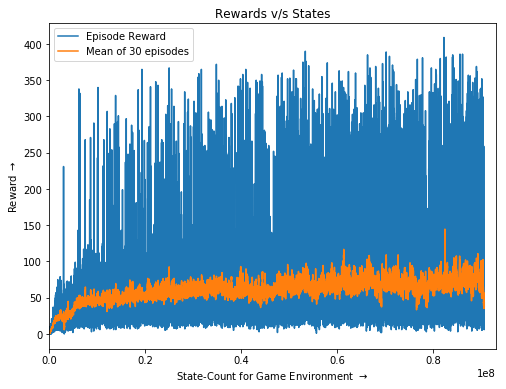

In [11]:
'''
Note: log_reward.count_states this contains all the values related states but in the form of tuple. 
        Hence it is better to convert them to list of integers. 
        
These were the old commands that I tried but didn't work properly during the plot 
(they also take lot of time to plot):
    plt.plot(log_reward.count_states, log_reward.episode, label='Episode Reward')
    plt.plot(log_reward.count_states, log_reward.mean, label='Mean of 30 episodes')
    
Also we need to change the args of xlim based on what was the last value of the total state stored. 
'''
states_nparray = np.array(log_reward.count_states)
states_list = []
for i in range(0, states_nparray.shape[0]):
    states_list.append(int(states_nparray[i]))

plt.figure(figsize=(8, 6))
plt.plot(states_list, log_reward.episode, label='Episode Reward')
plt.plot(states_list, log_reward.mean, label='Mean of 30 episodes')
plt.xlabel(r'State-Count for Game Environment $\rightarrow$')
plt.ylabel(r'Reward $\rightarrow$')
plt.title('Rewards v/s States')
plt.legend()
plt.xlim(0, 0.93e8)
plt.savefig('1.pdf')
plt.show()

## Training Progress: Q-Values
The following plot shows the mean Q-values from the replay-memory prior to each run of the optimizer for the Neural Network. Note how the mean Q-values increase rapidly in the beginning and then they increase fairly steadily for 40 million states, after which they still trend upwards but somewhat more irregularly.

The fast improvement in the beginning is probably due to 
- the use of a smaller replay-memory early in training so the Neural Network is optimized more often and the new information is used faster,
- the backwards-sweeping of the replay-memory so the rewards are used to update the Q-values for many of the states, instead of just updating the Q-values for a single state, and
- the replay-memory is balanced so at least half of each mini-batch contains states whose Q-values have high estimation-errors for the Neural Network.

The original paper from [DeepMind](https://arxiv.org/abs/1312.5602) showed much slower progress in the first phase of training, see Figure 2 in that paper but note that the Q-values are not directly comparable, possibly because they used a higher discount factor of 0.99 while we only used 0.97 here.

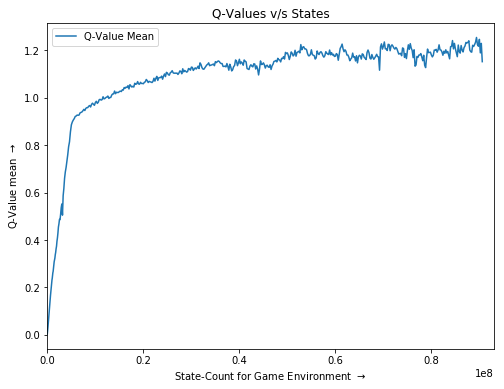

In [13]:
'''
Note: log_reward.count_states this contains all the values related states but in the form of tuple. 
        Hence it is better to convert them to list of integers. 
        
These were the old commands that I tried but didn't work properly during the plot
(they also take lot of time to plot):
    plt.plot(log_q_values.count_states, log_q_values.mean, label='Q-Value Mean')
    
Also we need to change the args of xlim based on what was the last value of the total state stored. 
'''
states_nparray = np.array(log_q_values.count_states)
states_list = []
for i in range(0, states_nparray.shape[0]):
    states_list.append(int(states_nparray[i]))

plt.figure(figsize=(8, 6))
plt.plot(states_list, log_q_values.mean, label='Q-Value Mean')
plt.xlabel(r'State-Count for Game Environment $\rightarrow$')
plt.ylabel(r'Q-Value mean $\rightarrow$')
plt.title('Q-Values v/s States')
plt.legend()
plt.xlim(0, 0.93e8)
plt.savefig('2.pdf')
plt.show()

## Testing
When the agent and Neural Network is being trained, the epsilon-probability is typically decreased from 1.0 to 0.1 over a large number of steps, after which the probability is held fixed at 0.1. This means the probability is 0.1 or 10% that the agent will select a *random action in each step*, otherwise it will select the *action that has the highest Q-value*. This is known as the epsilon-greedy policy. The choice of 0.1 for the epsilon-probability is a compromise between taking the actions that are already known to be good, versus exploring new actions that might lead to even higher rewards or might lead to death of the agent.

Now we will modify our parameters as follow:
- During testing it is common to lower the epsilon-probability even further. We have set it to 0.01 as shown below.
- We instruct the agent that it should no longer perform training by changing the `training` boolean.
- We also reset the previous episode rewards.
- We can render the game-environment to screen so we can see the agent playing the game, by changing the `render` boolean.

In [14]:
agent.epsilon_greedy.epsilon_testing
agent.training = False
agent.reset_episode_rewards()
agent.render = True

We can now run a single episode by calling the `run()` function again. This should open a new window that shows the game being played by the agent.

**TODO:** Search for some alternatives to save the game output using video recoder and how do we resize the env output window. 

In [16]:
agent.run(num_episodes=1)

60340:90642030	Q-min: 1.477	Q-max: 1.511	Lives: 5	Reward: 1.0	Episode Mean: 61.0
60340:90642094	Q-min: 1.486	Q-max: 1.512	Lives: 5	Reward: 2.0	Episode Mean: 61.0
60340:90642155	Q-min: 1.522	Q-max: 1.588	Lives: 5	Reward: 3.0	Episode Mean: 61.0
60340:90642203	Q-min: 1.881	Q-max: 1.903	Lives: 5	Reward: 4.0	Episode Mean: 61.0
60340:90642235	Q-min: 1.831	Q-max: 1.874	Lives: 5	Reward: 5.0	Episode Mean: 61.0
60340:90642265	Q-min: 1.868	Q-max: 1.920	Lives: 5	Reward: 6.0	Episode Mean: 61.0
60340:90642293	Q-min: 1.680	Q-max: 1.775	Lives: 5	Reward: 7.0	Episode Mean: 61.0
60340:90642313	Q-min: 0.040	Q-max: 0.114	Lives: 4	Reward: 7.0	Episode Mean: 61.0
60340:90642356	Q-min: 1.728	Q-max: 1.766	Lives: 4	Reward: 8.0	Episode Mean: 61.0
60340:90642409	Q-min: 1.567	Q-max: 1.589	Lives: 4	Reward: 9.0	Episode Mean: 61.0
60340:90642471	Q-min: 1.561	Q-max: 1.626	Lives: 4	Reward: 10.0	Episode Mean: 61.0
60340:90642520	Q-min: 1.856	Q-max: 1.891	Lives: 4	Reward: 11.0	Episode Mean: 61.0
60340:90642551	Q-min: 1.80

## Testing: Mean Reward
The game-play is slightly random, both with regard to selecting actions using the epsilon-greedy policy, but also because the OpenAI Gym environment will repeat any action between 2-4 times, with the number chosen at random. So the reward of one episode is not an accurate estimate of the reward that can be expected in general from this agent. We need to run 30 or even 50 episodes to get a more accurate estimate of the reward that can be expected.

Hence we will do the following:
- We will first reset the previous episode rewards.
- We disable the screen-rendering so the game-environment runs much faster.
- We can now run 30 episodes. This records the rewards for each episode.

**Note:** `%%capture` prevents Juptyper Notebook printing in stdout. Open this [link](https://nbviewer.jupyter.org/github/ipython/ipython/blob/1.x/examples/notebooks/Cell%20Magics.ipynb) for more information. 

In [17]:
%%capture
agent.reset_episode_rewards()
agent.render = False
agent.run(num_episodes=30)

In [18]:
# We can now print some statistics for the episode rewards, which vary greatly from one episode to the next.
rewards = agent.episode_rewards
print("Rewards for {0} episodes:".format(len(rewards)))
print("- Min:   ", np.min(rewards))
print("- Mean:  ", np.mean(rewards))
print("- Max:   ", np.max(rewards))
print("- Stdev: ", np.std(rewards))

Rewards for 30 episodes:
- Min:    35.0
- Mean:   101.76666666666667
- Max:    294.0
- Stdev:  57.234420490548246


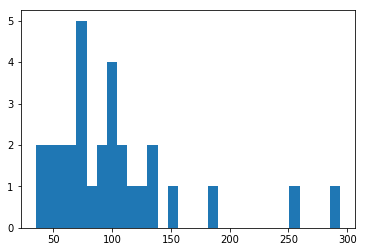

In [19]:
# We can also plot a histogram with the episode rewards.
plt.hist(rewards, bins=30)
plt.savefig('3.pdf')
plt.show()

## Helper functions for generating Examples
We can plot examples of states from the game-environment and the Q-values that are estimated by the Neural Network.

In [20]:
# This helper-function prints the Q-values for a given index in the replay-memory.
def print_q_values(idx):
    """Print Q-values and actions from the replay-memory at the given index."""

    # Get the Q-values and action from the replay-memory.
    q_values = replay_memory.q_values[idx]
    action = replay_memory.actions[idx]

    print("Action:     Q-Value:")
    print("====================")

    # Print all the actions and their Q-values.
    for i, q_value in enumerate(q_values):
        # Used to display which action was taken.
        if i == action:
            action_taken = "(Action Taken)"
        else:
            action_taken = ""

        # Text-name of the action.
        action_name = agent.get_action_name(i)
            
        print("{0:12}{1:.3f} {2}".format(action_name, q_value, action_taken))

    # Newline.
    print('\n')

In [21]:
# This helper-function plots a state from the replay-memory and optionally prints the Q-values.
def plot_state(idx, print_q=True):
    """Plot the state in the replay-memory with the given index."""

    # Get the state from the replay-memory.
    state = replay_memory.states[idx]
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(1, 2)

    # Plot the image from the game-environment.
    ax = axes.flat[0]
    ax.imshow(state[:, :, 0], vmin=0, vmax=255,
              interpolation='lanczos', cmap='gray')

    # Plot the motion-trace.
    ax = axes.flat[1]
    ax.imshow(state[:, :, 1], vmin=0, vmax=255,
              interpolation='lanczos', cmap='gray')
    plt.show()
    
    # Print the Q-values.
    if print_q:
        print_q_values(idx=idx)

In [22]:
'''
The replay-memory has room for 200k states but it is only partially full from the above call to 
agent.run(num_episodes=1). This is how many states are actually used.
'''
num_used = replay_memory.num_used
print('Number of states used in replay-memory: {0}'.format(num_used))

Number of states used in replay-memory: 1122


In [24]:
'''
We will get the Q-values from the replay-memory that are actually used. For each state, 
calculate the min/max Q-values and their difference. This will be used to lookup interesting states 
in the following sections.
'''
q_values = replay_memory.q_values[0:num_used, :]
q_values_min = q_values.min(axis=1)
q_values_max = q_values.max(axis=1)
q_values_dif = q_values_max - q_values_min

## Example: Highest Rewards
In this example we see the states surrounding the state with the highest reward.

During the training we limit the rewards to the range `[-1, 1]` so this basically just gets the first state that has a reward of 1. This state is where the ball hits the wall so the agent scores a point. We can show the surrounding states leading up to and following this state. 

**Note:** In the below set of figure we can see how the Q-values are very close for the different actions, because at this point it really does not matter what the agent does as the reward is already guaranteed. But note how the Q-values decrease significantly after the ball has hit the wall and a point has been scored. Also note that the agent uses the Epsilon-greedy policy for taking actions, so there is a small probability that a random action is taken instead of the action with the highest Q-value.

First index where we have max reward: 55


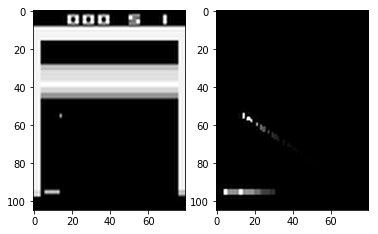

Action:     Q-Value:
NOOP        1.401 (Action Taken)
FIRE        1.391 
RIGHT       1.381 
LEFT        1.396 




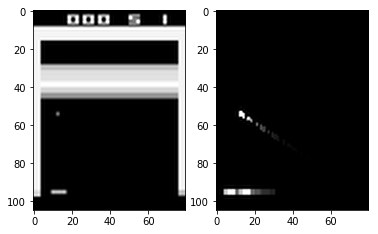

Action:     Q-Value:
NOOP        1.438 (Action Taken)
FIRE        1.404 
RIGHT       1.433 
LEFT        1.431 




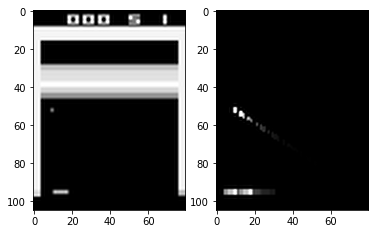

Action:     Q-Value:
NOOP        1.482 (Action Taken)
FIRE        1.434 
RIGHT       1.474 
LEFT        1.471 




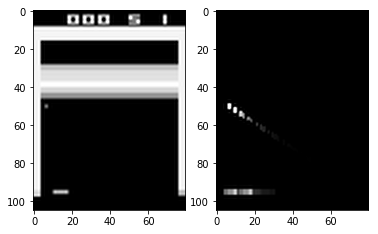

Action:     Q-Value:
NOOP        1.546 (Action Taken)
FIRE        1.483 
RIGHT       1.534 
LEFT        1.486 




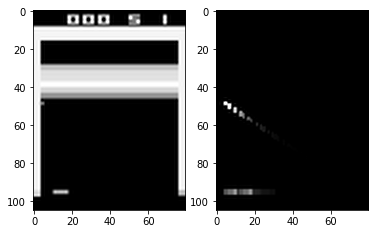

Action:     Q-Value:
NOOP        1.517 
FIRE        1.513 
RIGHT       1.528 (Action Taken)
LEFT        1.508 




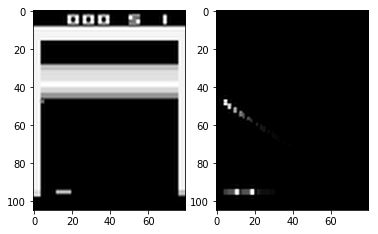

Action:     Q-Value:
NOOP        1.548 (Action Taken)
FIRE        1.518 
RIGHT       1.473 
LEFT        1.453 




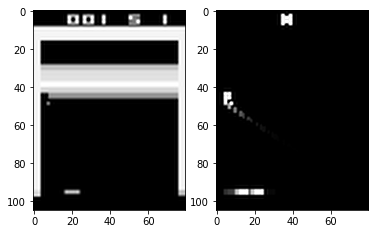

Action:     Q-Value:
NOOP        0.551 
FIRE        0.545 
RIGHT       0.555 (Action Taken)
LEFT        0.521 




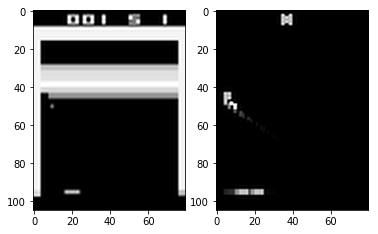

Action:     Q-Value:
NOOP        0.568 
FIRE        0.563 
RIGHT       0.580 (Action Taken)
LEFT        0.555 




In [25]:
idx = np.argmax(replay_memory.rewards)
print('First index where we have max reward: {0}'.format(idx))
for i in range(-5, 3):
    plot_state(idx=idx+i)

## Example: Highest Q-Value
In this example we see the states surrounding the one with the highest Q-values. 

This means that the agent has high expectation that several points will be scored in the following steps. Note that the Q-values decrease significantly after the points have been scored. Which is correct observation because once we have scored a point it hard to tell what happens in future/next hence any action we take have low Q-values. 

Index where we have highest Q-value: 1086


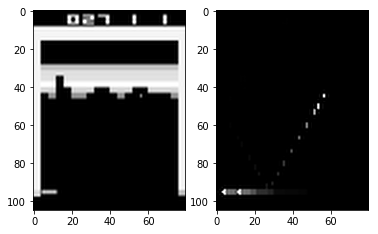

Action:     Q-Value:
NOOP        2.421 (Action Taken)
FIRE        2.239 
RIGHT       2.179 
LEFT        2.225 




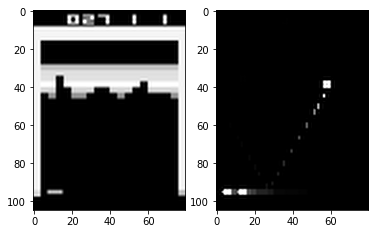

Action:     Q-Value:
NOOP        1.282 
FIRE        1.316 
RIGHT       1.396 (Action Taken)
LEFT        1.262 




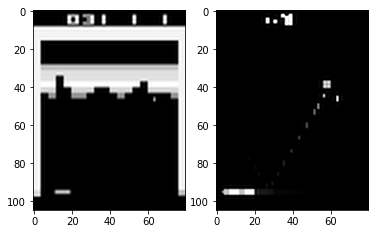

Action:     Q-Value:
NOOP        1.299 
FIRE        1.354 
RIGHT       1.431 (Action Taken)
LEFT        1.386 




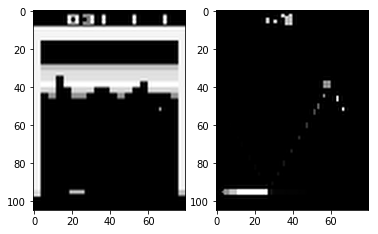

Action:     Q-Value:
NOOP        1.298 
FIRE        1.258 
RIGHT       1.498 (Action Taken)
LEFT        1.449 




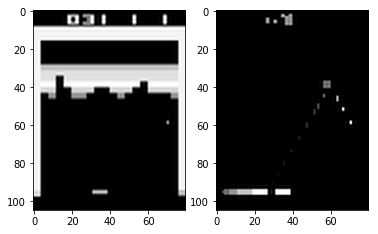

Action:     Q-Value:
NOOP        1.414 
FIRE        1.426 (Action Taken)
RIGHT       1.538 
LEFT        1.470 




In [26]:
idx = np.argmax(q_values_max)
print('Index where we have highest Q-value: {0}'.format(idx))
for i in range(0, 5):
    plot_state(idx=idx+i)

## Example: Loss of life
In this example we see the states leading up to a loss of life for the agent.

Index where we have loss of life: 294


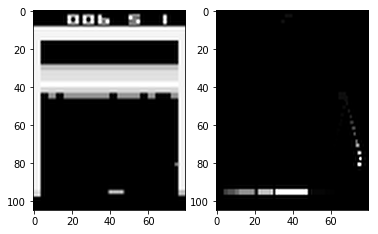

Action:     Q-Value:
NOOP        1.046 
FIRE        1.043 
RIGHT       1.083 (Action Taken)
LEFT        0.983 




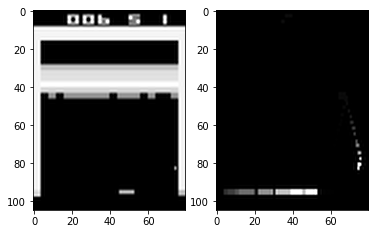

Action:     Q-Value:
NOOP        1.161 
FIRE        1.170 (Action Taken)
RIGHT       1.165 
LEFT        1.103 




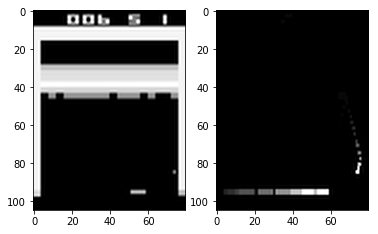

Action:     Q-Value:
NOOP        1.108 
FIRE        1.158 (Action Taken)
RIGHT       1.137 
LEFT        0.988 




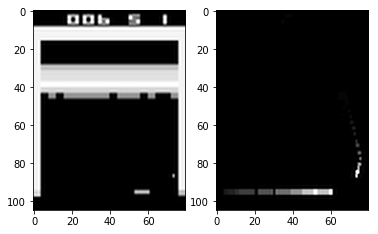

Action:     Q-Value:
NOOP        0.881 
FIRE        0.987 
RIGHT       1.103 (Action Taken)
LEFT        0.574 




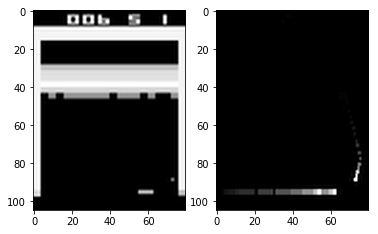

Action:     Q-Value:
NOOP        1.191 
FIRE        1.160 (Action Taken)
RIGHT       1.215 
LEFT        1.040 




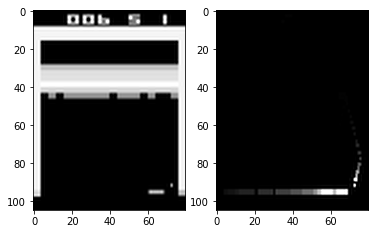

Action:     Q-Value:
NOOP        1.145 
FIRE        1.096 (Action Taken)
RIGHT       1.213 
LEFT        0.984 




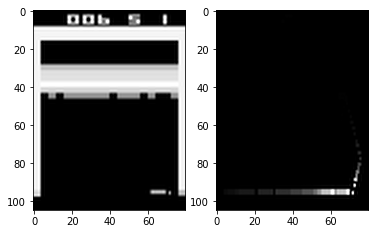

Action:     Q-Value:
NOOP        0.875 
FIRE        0.904 
RIGHT       0.981 (Action Taken)
LEFT        0.823 




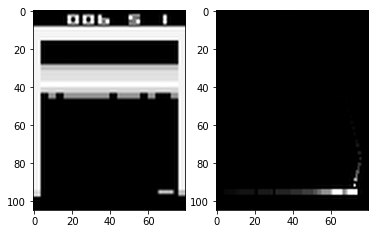

Action:     Q-Value:
NOOP        0.391 
FIRE        0.427 
RIGHT       0.553 (Action Taken)
LEFT        0.490 




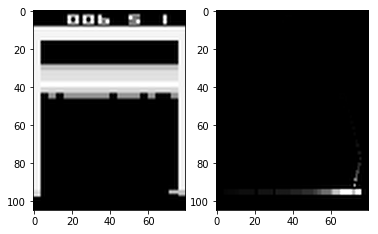

Action:     Q-Value:
NOOP        0.026 
FIRE        0.049 
RIGHT       0.182 
LEFT        0.187 (Action Taken)




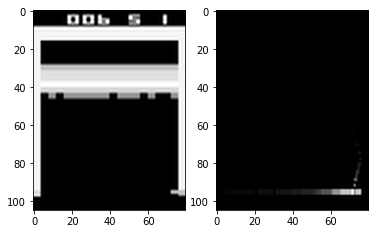

Action:     Q-Value:
NOOP        0.072 
FIRE        0.120 
RIGHT       0.177 (Action Taken)
LEFT        0.032 




In [27]:
idx = np.argmax(replay_memory.end_life)
print('Index where we have loss of life: {0}'.format(idx))
for i in range(-10, 0):
    plot_state(idx=idx+i)

## Example: Greatest Difference in Q-Values
In this example we see the state where there is the greatest difference in Q-values. 

Which means that the agent believes one action will be much more beneficial than another. But because the agent uses the Epsilon-greedy policy, it sometimes selects a random action instead.

Index where we have greatest difference in Q-values: 1120


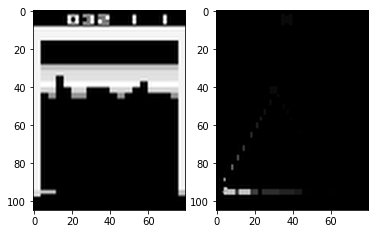

Action:     Q-Value:
NOOP        0.849 
FIRE        1.138 
RIGHT       -0.129 
LEFT        1.492 (Action Taken)




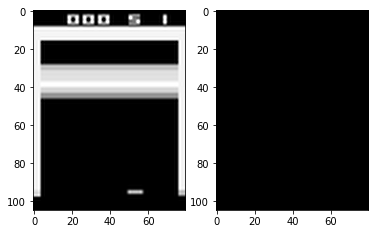

Action:     Q-Value:
NOOP        0.537 
FIRE        0.621 (Action Taken)
RIGHT       0.594 
LEFT        0.598 




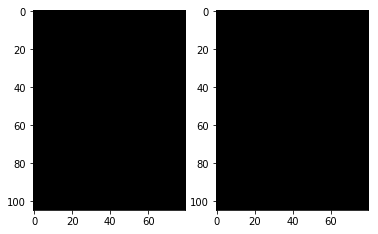

Action:     Q-Value:
NOOP        0.000 (Action Taken)
FIRE        0.000 
RIGHT       0.000 
LEFT        0.000 




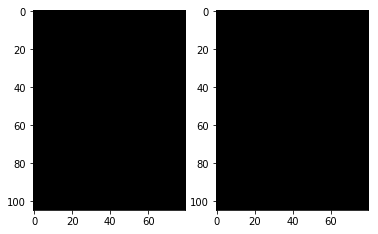

Action:     Q-Value:
NOOP        0.000 (Action Taken)
FIRE        0.000 
RIGHT       0.000 
LEFT        0.000 




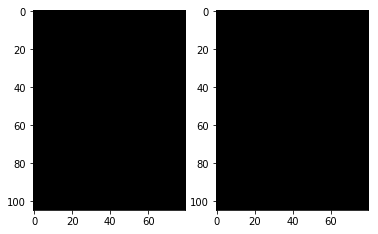

Action:     Q-Value:
NOOP        0.000 (Action Taken)
FIRE        0.000 
RIGHT       0.000 
LEFT        0.000 




In [28]:
idx = np.argmax(q_values_dif)
print('Index where we have greatest difference in Q-values: {0}'.format(idx))
for i in range(0, 5):
    plot_state(idx=idx+i)

## Example: Smallest Difference in Q-Values
In this example we see the state where there is the smallest difference in Q-values. 

Which means that the agent believes it does not really matter which action it selects, as they all have roughly the same expectations for future rewards. The Neural Network estimates these Q-values and they are not precise. The differences in Q-values may be so small that they fall within the error-range of the estimates.

Index where we have smallest difference in Q-values: 464


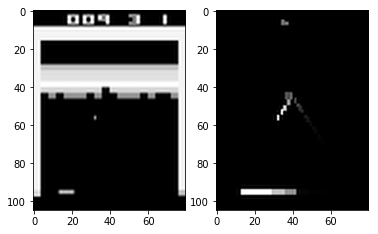

Action:     Q-Value:
NOOP        0.871 
FIRE        0.872 
RIGHT       0.872 
LEFT        0.873 (Action Taken)




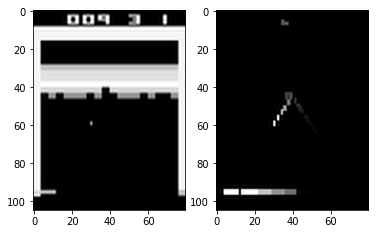

Action:     Q-Value:
NOOP        0.916 
FIRE        0.906 
RIGHT       0.904 
LEFT        0.922 (Action Taken)




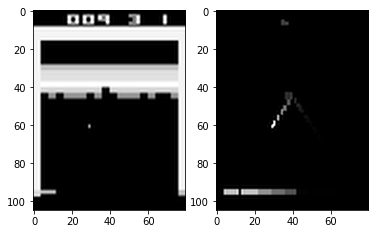

Action:     Q-Value:
NOOP        0.908 
FIRE        0.906 
RIGHT       0.920 (Action Taken)
LEFT        0.919 




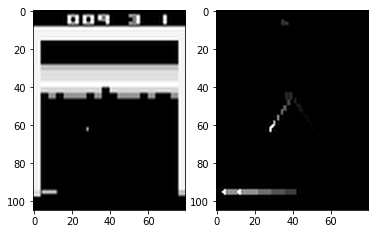

Action:     Q-Value:
NOOP        0.871 
FIRE        0.882 (Action Taken)
RIGHT       0.880 
LEFT        0.874 




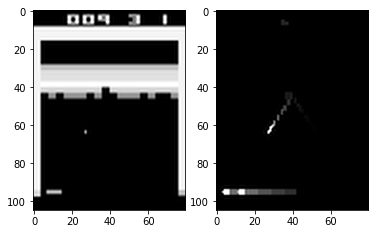

Action:     Q-Value:
NOOP        0.877 
FIRE        0.895 
RIGHT       0.895 (Action Taken)
LEFT        0.864 




In [29]:
idx = np.argmin(q_values_dif)
print('Index where we have smallest difference in Q-values: {0}'.format(idx))
for i in range(0, 5):
    plot_state(idx=idx+i)

# Part 3

## Output of Convolutional Layers

In [30]:
# This is the helper-function for plotting the output of the convolutional layer with the given name
# when inputting the given state from the replay-memory.
def plot_layer_output(model, layer_name, state_index, inverse_cmap=False):
    """
    Plot the output of a convolutional layer.

    :param model: An instance of the NeuralNetwork-class.
    :param layer_name: Name of the convolutional layer.
    :param state_index: Index into the replay-memory for a state that
                        will be input to the Neural Network.
    :param inverse_cmap: Boolean whether to inverse the color-map.
    """

    # Get the given state-array from the replay-memory.
    state = replay_memory.states[state_index]
    
    # Get the output tensor for the given layer inside the TensorFlow graph.
    # This is not the value-contents but merely a reference to the tensor.
    layer_tensor = model.get_layer_tensor(layer_name=layer_name)
    
    # Get the actual value of the tensor by feeding the state-data
    # to the TensorFlow graph and calculating the value of the tensor.
    values = model.get_tensor_value(tensor=layer_tensor, state=state)

    # Number of image channels output by the convolutional layer.
    num_images = values.shape[3]
    
    # Simple way of solving the num_grids issue if you want this then uncomment the bottom line
    # comment the bottom if-else part
    # Number of grid-cells to plot.
    # Rounded-up, square-root of the number of filters.
    # **Uncomment the following**
    # num_grids = np.ceil(np.sqrt(num_images))
    # # Create figure with a grid of sub-plots.
    # fig, axes = plt.subplots(num_grids, num_grids, figsize=(10, 10))
    
    # NOTE:
    # Since we know that output of Conv_Layer_2 will be 32 images which is not 
    # a square we can do little hack to make the output plot better. But this will not
    # work if outputs of the Conv layers are not odd powers of 2 
    # i.e. no of filters we use in a layer should be powers of 2.  
    num_grids = int(np.ceil(np.sqrt(num_images)))
    if num_grids**2 == num_images:
        # Create figure with a grid of sub-plots.
        fig, axes = plt.subplots(num_grids, num_grids, figsize=(10, 10))
    else:
        a = np.log(num_images)/np.log(2)
        num_grids_1 = np.power(2, int((a+1)/2))
        num_grids_2 = np.power(2, int((a-1)/2))
        # Create figure with a grid of sub-plots.
        fig, axes = plt.subplots(num_grids_1, num_grids_2, figsize=(10, 10))        

    print("Dim. of each image:", values.shape)
    
    if inverse_cmap:
        cmap = 'gray_r'
    else:
        cmap = 'gray'

    # Plot the outputs of all the channels in the conv-layer.
    for i, ax in enumerate(axes.flat):
        # Only plot the valid image-channels.
        if i < num_images:
            # Get the image for the i'th output channel.
            img = values[0, :, :, i]

            # Plot image.
            ax.imshow(img, interpolation='nearest', cmap=cmap)

        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.savefig(layer_name+'_output.pdf')
    plt.show()

## Game state input
This is the state we will input to the CNN. The image on the left is the last image from the game-environment. The image on the right is the processed motion-trace that shows the trajectories of objects in the game-environment.

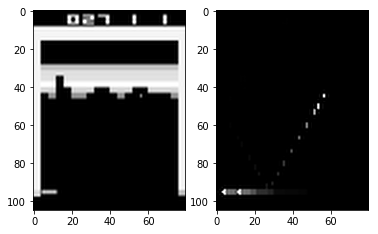

In [31]:
idx = np.argmax(q_values_max)
plot_state(idx=idx, print_q=False)

## Output of Convolutional Layer 1
This shows the images that are output by the 1st convolutional layer, when inputting the above state to the Neural Network. There are 16 output channels of this convolutional layer.

**Note:** that you can invert the colors by setting `inverse_cmap=True` in the parameters to this function.

Dim. of each image: (1, 53, 40, 16)


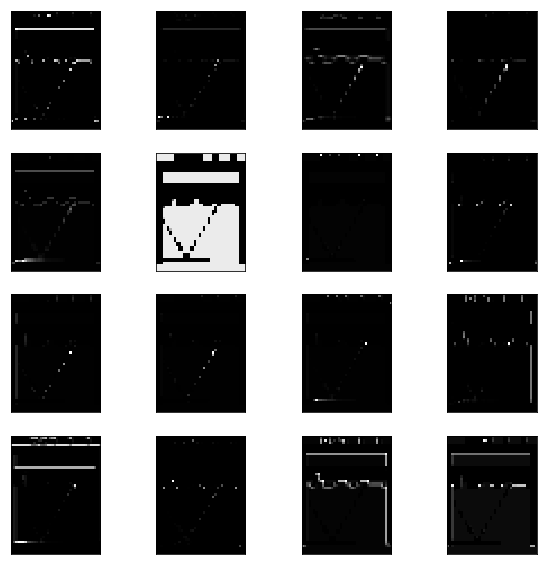

In [32]:
plot_layer_output(model=model, layer_name='layer_conv1', state_index=idx, inverse_cmap=False)

## Output of Convolutional Layer 2
These are the images output by the 2nd convolutional layer, when inputting the above state to the Neural Network. There are 32 output channels of this convolutional layer.

Dim. of each image: (1, 27, 20, 32)


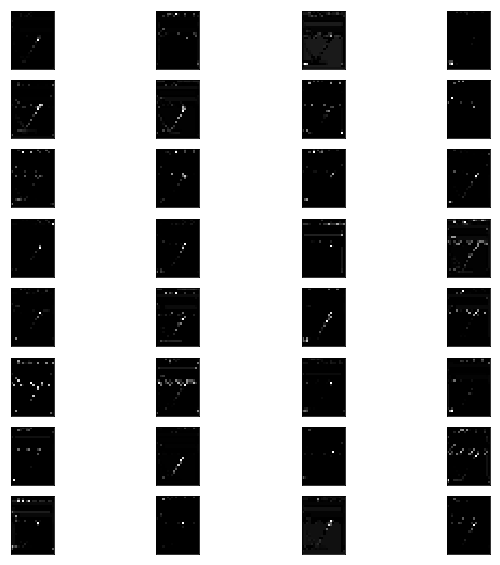

In [33]:
plot_layer_output(model=model, layer_name='layer_conv2', state_index=idx, inverse_cmap=False)

## Output of Convolutional Layer 3
These are the images output by the 3rd convolutional layer, when inputting the above state to the Neural Network. There are 64 output channels of this convolutional layer. All these images are flattened to a one-dimensional array (or tensor) which is then used as the input to a fully-connected layer in the Neural Network. During the training-process, the Neural Network has learnt what convolutional filters to apply to the images from the game-environment so as to produce these images, because they have proven to be useful when estimating Q-values.


Dim. of each image: (1, 27, 20, 64)


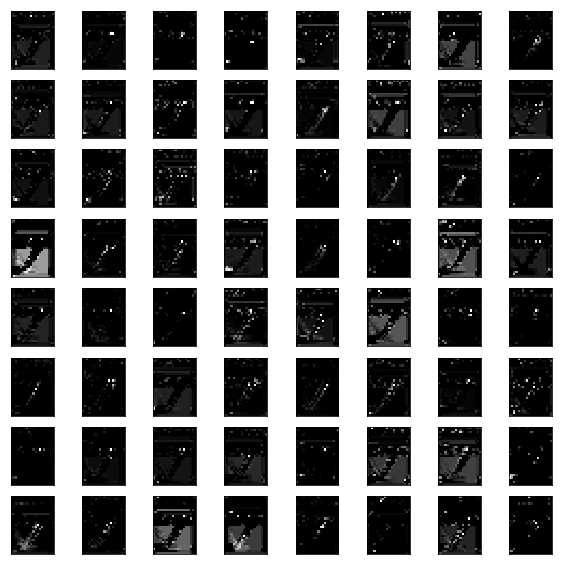

In [34]:
plot_layer_output(model=model, layer_name='layer_conv3', state_index=idx, inverse_cmap=False)

## Weights for Convolutional Layers
We can also plot the weights of the convolutional layers in the Neural Network. These are the weights that are being optimized so as to improve the ability of the Neural Network to estimate Q-values.

**Remember:** how tensorflow sees each image and filter of a convolution layer
- Image: `[batch, in_height, in_width, in_channels]`
- Filter: `[filter_height, filter_width, in_channels, out_channels]`

In [35]:
def plot_conv_weights(model, layer_name, filter_no=0, color_map='seismic'):
    """
    Plot the weights for a convolutional layer.
    
    :param model: An instance of the NeuralNetwork-class.
    :param layer_name: Name of the convolutional layer.
    :param input_channel: Plot the weights for this input-channel.
    """
    # Assume weights are TensorFlow ops for 4-dim variables
    # e.g. weights_conv1 or weights_conv2.  
    # Get the variable for the weights of the given layer.
    # This is a reference to the variable inside TensorFlow,
    # not its actual value.
    weights_variable = model.get_weights_variable(layer_name=layer_name)
    
    # Retrieve the values of the weight-variable from TensorFlow.
    # The format of this 4-dim tensor is determined by the
    # TensorFlow API.
    w = model.get_variable_value(variable=weights_variable)
    
    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)
    
    # Print statistics for the weights for that layer.
    print("Min:  {0:.5f}, Max:   {1:.5f}".format(w_min, w_max))
    print("Mean: {0:.5f}, Stdev: {1:.5f}".format(w.mean(), w.std()))

    # Number of filters used in the conv. layer.
    num_filters = w.shape[3]
    
    # Number of channels used in the conv. layer.
    num_channels = w.shape[2]
    
    # If we want to plot on filter then it would be of size (filter_height x filter_width x num_channels)
    # In total we will have num_filters no. of filters
    # Number of grids to plot.
    # Rounded-up, square-root of the number of channels
    num_grids = int(np.ceil(np.sqrt(num_channels)))
    
    # Check if the input has only one channel
    if num_grids == 1:
        print('Filter Shape:', w.shape[0], 'x', w.shape[1])
        print('Filter Channels:', num_channels)
        print('Hence each filter shape:', w.shape[0], 'x', w.shape[0], 'x', num_channels)
        print('Total no. of filters:', num_filters)
        print('Plotting ALL the Filters')
        new_num_grids = int(np.ceil(np.sqrt(num_filters)))
        fig, axes = plt.subplots(new_num_grids, new_num_grids)
        for i, ax in enumerate(axes.flat):
            # Plot the image
            img = w[:, :, 0, i]
            ax.imshow(img, vmin=w_min, vmax=w_max, interpolation='nearest', cmap=color_map)
            # Remove ticks from the plot.
            ax.set_xticks([])
            ax.set_yticks([])
        plt.savefig(layer_name+'_weights_allfilters.pdf')
        plt.show()
    else:
        # Check if the input channels is square or odd power of 2
        # If both if-else conditions are not satisified then it will not plot properly
        if num_grids**2 == num_channels:
            # Create figure with a grid of sub-plots.
            fig, axes = plt.subplots(num_grids, num_grids)
        else:
            a = np.log(num_channels)/np.log(2)
            num_grids_1 = np.power(2, int((a+1)/2))
            num_grids_2 = np.power(2, int((a-1)/2))
            # Create figure with a grid of sub-plots.
            fig, axes = plt.subplots(num_grids_1, num_grids_2) 
        print('Filter Shape:', w.shape[0], 'x', w.shape[1])
        print('Filter Channels:', num_channels)
        print('Hence each filter shape:', w.shape[0], 'x', w.shape[1], 'x', num_channels)
        print('Total no. of filters:', num_filters)
        print('Plotting filter number:', filter_no)
        # Plot all the filter-weights.
        for i, ax in enumerate(axes.flat):
            # Get the weights for the i'th filter of the input channel.
            # See new_conv_layer() for details on the format
            # of this 4-dim tensor.
            img = w[:, :, i, filter_no]
            # Plot image.
            ax.imshow(img, vmin=w_min, vmax=w_max, interpolation='nearest', cmap=color_map)
            # Remove ticks from the plot.
            ax.set_xticks([])
            ax.set_yticks([])
        # Ensure the plot is shown correctly with multiple plots
        # in a single Notebook cell.
        plt.savefig(layer_name+'_weights_filter_'+str(filter_no)+'.pdf')
        plt.show()

## Weights for Convolutional Layer 1
These are the weights of the first filter of the convolutional layer of the Neural Network. Some basic statistics are also shown.

Min:  -0.80178, Max:   0.13927
Mean: -0.03925, Stdev: 0.11840
Filter Shape: 3 x 3
Filter Channels: 2
Hence each filter shape: 3 x 3 x 2
Total no. of filters: 16
Plotting filter number: 0


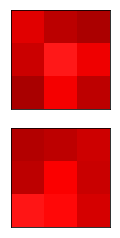

In [36]:
plot_conv_weights(model=model, layer_name='layer_conv1', filter_no=0)

We can also plot the convolutional weights for the second filter.

Min:  -0.80178, Max:   0.13927
Mean: -0.03925, Stdev: 0.11840
Filter Shape: 3 x 3
Filter Channels: 2
Hence each filter shape: 3 x 3 x 2
Total no. of filters: 16
Plotting filter number: 1


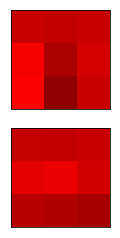

In [37]:
plot_conv_weights(model=model, layer_name='layer_conv1', filter_no=1)

## Weights for Convolutional Layer 2
These are the weights of the first filter in 2nd convolutional layer in the Neural Network. There are 16 input channels and 32 output channels of this layer. We can change the filter number and plot weights for another filter. 

Min:  -0.50973, Max:   0.31799
Mean: -0.00957, Stdev: 0.09336
Filter Shape: 3 x 3
Filter Channels: 16
Hence each filter shape: 3 x 3 x 16
Total no. of filters: 32
Plotting filter number: 0


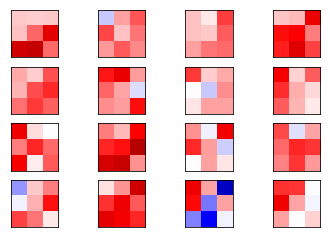

In [38]:
plot_conv_weights(model=model, layer_name='layer_conv2', filter_no=0)

## Weights for Convolutional Layer 3
These are the weights of the first filter in 3rd convolutional layer in the Neural Network. There are 32 input channels and 64 output channels of this layer. We can change the filter number and plot weights for another filter. 

Min:  -0.51606, Max:   0.39941
Mean: -0.01866, Stdev: 0.09459
Filter Shape: 3 x 3
Filter Channels: 32
Hence each filter shape: 3 x 3 x 32
Total no. of filters: 64
Plotting filter number: 0


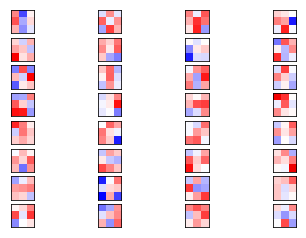

In [39]:
plot_conv_weights(model=model, layer_name='layer_conv3', filter_no=0)

## Additional Code
This is a small code for downloading an image of the OpenAI game envoirnment. 

In [40]:
# Save the image of Breakout-v0 env
import gym
# import six
env = gym.make('Breakout-v0')
env.reset()
env.env.ale.saveScreenPNG(b'Breakout-v0_test_image.png')
# env.env.ale.saveScreenPNG(six.b('test_image.png'))